Script to fit stokes parameters db202; based on example2.py script in seek.

In [1]:
# Needed libraries
#
import numpy as np
from scipy.io import FortranFile
from pylab import *
from matplotlib import pyplot as plt
from scipy import stats
import time
import sys
import os
import importlib
import pickle
import h5py
import cle202_utils_phil as cle202_utils   # there is a cle.py that must be in the same
                    # directory as this file
importlib.reload(cle202_utils)
    
np.set_printoptions(precision=3,suppress=False)
plt.rcParams["figure.figsize"] = [10,10]
matplotlib.rcParams.update({'font.size': 12})

# colorbar function to have nice colorbars in figures
def colorbar(mappable):
   from mpl_toolkits.axes_grid1 import make_axes_locatable
   import matplotlib.pyplot as plt
   last_axes = plt.gca()
   ax = mappable.axes
   fig = ax.figure
   divider = make_axes_locatable(ax)
   cax = divider.append_axes("right", size="3.5%", pad=0.05)
   cbar = fig.colorbar(mappable, cax=cax)
   #cbar.formatter.set_powerlimits((4, 9))
   plt.sca(last_axes)
   return cbar

<Figure size 1080x1080 with 0 Axes>

In [3]:
## Simple tests
# sobs=np.array([2.77147984e+00,-1.30364644e-02,-8.49817523e-03,-5.08774743e-02,1.90001667e+00,-3.30449505e-04,-2.13886508e-04,-7.47483540e-02]) #D1
# sobs=np.array([2.72472332e+00,-1.47195132e-04,-2.54103877e-05,-1.67518594e-01,1.67537050e+00,-4.83628247e-06,-8.17960103e-07,-2.43508440e-01]) #D2

# #Edges od C A and B

# sobs=np.double([0.03912, 0.0017923207001816115, 0.0027558121321491595, -5.824e-07, 0.02063, 3.0781595509210556e-05, 4.733387241613925e-05, -6.166e-07]) #C
# sobs=np.double([0.4867, 0.003066000964161143, 0.0038257662092400445, -0.002558, 0.3269, 7.746810298818352e-05, 9.666138535843664e-05, -0.003841]) #A
# sobs=np.double([0.9399, 0.003952474920263756, 0.006477753237403075, -0.01077, 0.5973, 0.00011603186228464473, 0.00019016789144005682, -0.01566]) #B

In [4]:
# ##controling parameters for simple tests
# counts=1.e6

# sobs/=sobs[0]          # normalized
# sobs*=counts           # number of counts in each sobs
# # First, here is variance of each state with counts electrons
# #
# # Here is variance vars in ((I+S) - (I-S))/2 = S, in counts
# #
# vars = (counts + counts)/2.
# #
# # here is the variance in y = S/I:  var(y)/y^2 = var(S)/S^2 + var(I)/I^2
# #
# var =  vars/sobs**2 + counts/sobs[0]**2
# var *= (sobs/sobs[0])**2
# rms=np.sqrt(var)
# #

# # Now add noise to the fake observations
# #
# #sobs = sobs * ( 1. + rms*np.random.normal(0.,1,sobs.shape) )

# sobs/=counts ## remember to divide back by the counts

# dbdir='/home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_deg_150_fe13/'
# nl=1

# #Height of the observation

# ##yobs for 3dipole simulation
# #yobs_d1=1.11
# #yobs_d2=1.02
# yobs=1.20 #C
# yobs=1.13 #A
# yobs=1.07 #B

## MURAM processing

In [2]:
##if data is muram take a boolean variable to compute controlling parameters
mur=1

#Read the muram data
f1a = h5py.File('/home/alin/Desktop/cle-invert/hh2-muram/Fe13_10747_hires_spectra_050000.hdf5','r')
f1b = h5py.File('/home/alin/Desktop/cle-invert/hh2-muram/Fe13_10747_hires_tot_IQU_050000.hdf5','r')
f2a = h5py.File('/home/alin/Desktop/cle-invert/hh2-muram/Fe13_10798_hires_spectra_050000.hdf5','r')
f2b = h5py.File('/home/alin/Desktop/cle-invert/hh2-muram/Fe13_10798_hires_tot_IQU_050000.hdf5','r')

## get the actual array sizez in wavelenght x and y domains
wvl=f1a['stokes'].shape[1]
xxl=f1a['stokes'].shape[2]
yyl=f1a['stokes'].shape[3]
## get the acual (array) scales for the wavelength and spatial axes
## they should be the same for the two data sets 
wvvec1 = f1a['stokes'].dims[1][0][:]
wvvec2 = f2a['stokes'].dims[1][0][:]
yvec = f1a['stokes'].dims[2][0][:]
xvec = f1a['stokes'].dims[3][0][:]

# ##compute the total integrated signals.
# f1aa=np.sum(f1a['stokes'],axis=1)
# f2aa=np.sum(f2a['stokes'],axis=1)
# ## next part actually integrates Stokes V withoutthe cancellation of the signal from the sign inversion
# f1aaa=np.zeros((101,1024,1024))
# f2aaa=np.zeros((101,1024,1024))
# f1aaa=np.copy(f1a['stokes'][3,:,:,:])
# f2aaa=np.copy(f2a['stokes'][3,:,:,:])
# for xx in range(0,xxl):
#     print("bla:",xx)
#     for yy in range(0,yyl):
#         min1=(np.where(f1aaa[:,xx,yy] == np.min(f1aaa[:,xx,yy]) ) )[0][0]
#         max1=(np.where(f1aaa[:,xx,yy] == np.max(f1aaa[:,xx,yy]) ) )[0][0]
#         min2=(np.where(f2aaa[:,xx,yy] == np.min(f2aaa[:,xx,yy]) ) )[0][0]
#         max2=(np.where(f2aaa[:,xx,yy] == np.max(f2aaa[:,xx,yy]) ) )[0][0]
#         if (min1 < max1):
#             f1aa[3,xx,yy]=-np.sum(np.abs(f1a['stokes'][3,:,xx,yy]),axis=0)
#         else:
#             f1aa[3,xx,yy]= np.sum(np.abs(f1a['stokes'][3,:,xx,yy]),axis=0)
#         if (min2 < max2):
#             f2aa[3,xx,yy]=-np.sum(np.abs(f2a['stokes'][3,:,xx,yy]),axis=0)
#         else:
#             f2aa[3,xx,yy]= np.sum(np.abs(f2a['stokes'][3,:,xx,yy]),axis=0)
# plt.figure()
# plt.imshow(f1aa[3,:,:])
#             # sobs is the observed Stokes array (nline*4)
nuse=2## these are the data in the muram cube, not really alterable. Unless you want to try just one line.


1074.257137234178 1074.6081782460114
0.0071641022823314415
0.0071985362681061815
[-7.488 -7.44  -7.392 ... 41.52  41.568 41.616]
[-49.104 -49.008 -48.912 ...  48.912  49.008  49.104]
[0.989 0.989 0.989 ... 1.06  1.06  1.06 ] (1024,)
[-0.071 -0.07  -0.07  ...  0.07   0.07   0.071] (1024,)
0.0006899525657622085
0.0013799051315221966


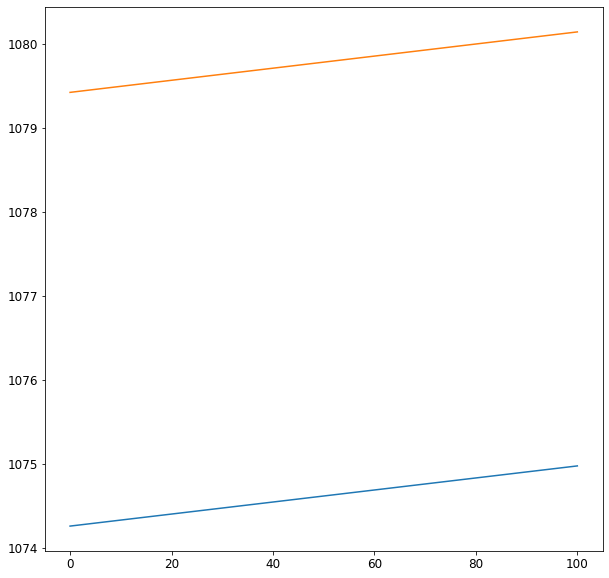

In [30]:
print(wvvec1[0],wvvec1[np.int32(wvl/2)-1])

print(wvvec1[50]-wvvec1[49])
print(wvvec2[50]-wvvec2[49])
plt.plot(wvvec1)
plt.plot(wvvec2)
print(xvec)
print(yvec)


print((xvec+695.7)/695.7,xvec.shape)
print((yvec+695.7)/695.7-1,yvec.shape)

print(((xvec[555]+695.7)/695.7-(xvec[554]+695.7)/695.7)*10)
print(((yvec[555]+695.7)/695.7-(yvec[554]+695.7)/695.7)*10)

In [6]:
#with open('mstokes.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#   pickle.dump([f1aa,f2aa], f)

In [7]:
# with open('mstokes.pkl','rb') as f:
#     f1aa,f2aa = pickle.load(f)

In [9]:
xx=0
yy=0
print(f1a['stokes'].shape)
sobs=[f1a['stokes'][0,:,xx,yy],f1a['stokes'][1,:,xx,yy],f1a['stokes'][2,:,xx,yy],f1a['stokes'][3,:,xx,yy],f2a['stokes'][0,:,xx,yy],f2a['stokes'][1,:,xx,yy],f2a['stokes'][2,:,xx,yy],f2a['stokes'][3,:,xx,yy]]
print(len(sobs))

(4, 101, 1024, 1024)
8


In [13]:
##form the arrays and prepare the observation files
##use the full observation
sobs_a=np.zeros((xxl,yyl,wvl,4*nuse), dtype=float64)
yobs_a=np.zeros((xxl,yyl),dtype=float64)
stats_a=np.zeros((xxl,yyl,2,),dtype=float64) #first dimension is the input RMS 2nd dimension is the output fit chi2

# counts=1.e6 controling parameter for noise estimation.
from numba import prange

for xx in range(0,xxl):
    print(xx)
    for yy in range(0,yyl):
        ##use sobs to minimize the amount of subscription of arrays and then subscribe sobs_a only once
        #sobs=[f1aa[0,xx,yy],f1aa[1,xx,yy],f1aa[2,xx,yy],f1aa[3,xx,yy],f2aa[0,xx,yy],f2aa[1,xx,yy],f2aa[2,xx,yy],f2aa[3,xx,yy]]   ## integrated
        #sobs=[f1a[0,:,xx,yy],f1a[1,:,xx,yy],f1a[2,:,xx,yy],f1a[3,:,xx,yy],f2a[0,:,xx,yy],f2a[1,:,xx,yy],f2a[2,:,xx,yy],f2a[3,:,xx,yy]]   ## spectra       
        #sobs= sobs/np.max(sobs)
#         # Commented, to be implemented later when we are sure how to interpret shot noise.

#         sobs*=counts           # number of counts in each sobs
#         # First, here is variance of each state with counts electrons
#         #
#         # Here is variance vars in ((I+S) - (I-S))/2 = S, in counts
#         #
#         vars = (counts + counts)/2.
#         #
#         # here is the variance in y = S/I:  var(y)/y^2 = var(S)/S^2 + var(I)/I^2
#         #
#         var =  vars/sobs**2 + counts/sobs[0]**2
#         var *= (sobs/sobs[0])**2
#         rms=np.sqrt(var)
#         #

#         # Now add noise to the fake observations
#         #
#         #sobs = sobs * ( 1. + rms*np.random.normal(0.,1,sobs.shape) )

#         sobs/=counts ## remember to divide back by the counts   
#         stats_a[xx,yy,0]=rms
        for zz in prange(0,4):
            sobs_a[xx,yy,:,zz]=f1a['stokes'][zz,:,xx,yy]
            sobs_a[xx,yy,:,zz+4]=f2a['stokes'][zz,:,xx,yy]
        #yobs_a[xx,yy]=np.sqrt( ((xvec[xx])/696.34)**2+((696.34+yvec[yy])/696.34)**2 )
#rms=np.ones(8) ## placeholder for clematch input

0
1
2
3
4
5


KeyboardInterrupt: 

In [3]:
sobsb=np.append(np.array(f1a['stokes']),np.array(f2a['stokes']),axis=0)

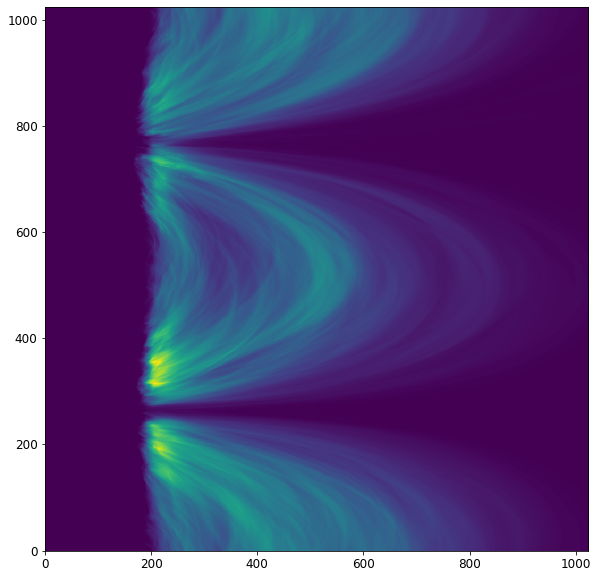

In [5]:
plt.figure()
plt.imshow(sobs1[0,50,:,:])

In [4]:
sobsa=np.zeros((1024,1024,101,8),dtype=np.float64)
from numba import prange

for i in prange(8):
    for j in prange(101):
        for k in prange(1024):
            for l in prange(1024):
                sobsa[k,l,j,i]=sobsb[i,j,k,l]

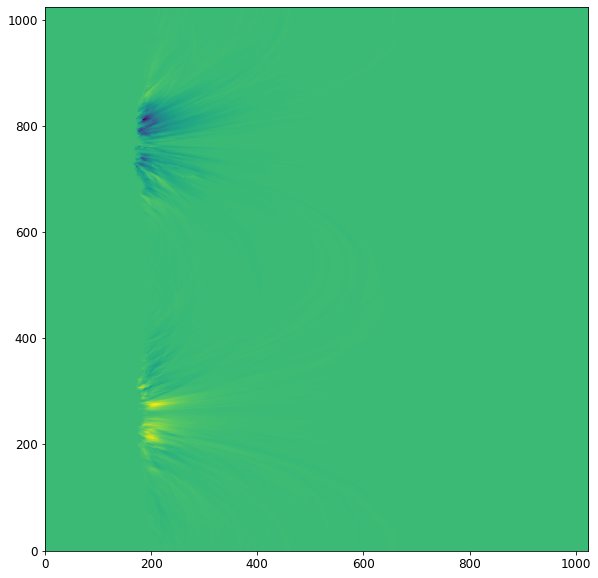

In [7]:
plt.figure()
plt.imshow(sobsa[:,:,50,3])

In [8]:
# # # Saving the objects:
#with open('obsstokes_avg_new.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#   pickle.dump([f1aa,f2aa,sobs_a,yobs_a,rms,wvl,xxl,yyl],f)
# with open('obsstokes_avg_muram2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([sobs_a,yobs_a,rms,xxl,yyl],f)
with open('obsstokes_avg_muram3.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump([sobsa],f)

In [4]:
with open('obsstokes_avg.pkl','rb') as f:
    f1aa,f2aa,sobs_a,yobs_a,rms,wvl,xxl,yyl = pickle.load(f)

In [ ]:
outparams_a=np.zeros((xxl,yyl,11,4),dtype=float64) #an array to store the first 4 solutions from the DB inversion
##outparams_a[3:5] are the b fields with phi and theta angles and outparams_a[6:8] are bx by bz scaled using the V_obs/V_db ratio
##outparams_a[9:10] are the DB index and chi2 values respectively.

start0=time.time()
dbdir='/home/alin/Documents/physics_prog/cle/test_cle_degeneracy/db202_deg_150_fe13/'
g=cle202_utils.readhdr(dbdir+'db.hdr')
for xx in range(0,xxl):
    print("bla:",xx)
    for yy in range(0,yyl):
        index,sdb,chisq,physics=cle202_utils.clematch(sobs_a[xx,yy,:],yobs_a[xx,yy],rms,iplot=0,verbose=0,maxchisq=100,dbdir=dbdir)
        #print(len(index.shape))
        if (len(index.shape) == 0):
            continue
        elif (index.shape[0] >= 4):
            for zz in range(0,4):
                outparams_a[xx,yy,0:6,zz]=cle202_utils.physa(index[zz],yobs_a[xx,yy],g,1)
                outparams_a[xx,yy,6:9,zz]=(cle202_utils.phys(index[zz],yobs_a[xx,yy],g,sobs_a[xx,yy,3]/sdb[zz][3]))[3:6]
                outparams_a[xx,yy,9,zz]=chisq[zz]
                outparams_a[xx,yy,10,zz]=index[zz]
        else:
            for zz in range(0,index.shape[0]):
                outparams_a[xx,yy,0:6,zz]=cle202_utils.physa(index[zz],yobs_a[xx,yy],g,1)
                outparams_a[xx,yy,6:9,zz]=(cle202_utils.phys(index[zz],yobs_a[xx,yy],g,sobs_a[xx,yy,3]/sdb[zz][3]))[3:6]
                outparams_a[xx,yy,9,zz]=chisq[zz]
                outparams_a[xx,yy,10,zz]=index[zz]

# print(index.shape[0])        
# numsol=size(index)
# print("sobs", sobs," found")
# print("sdb", sdb[0]," found")
# print("pogon",physics)
# ppp=cle202_utils.phys(index[0],yobs,g,sobs[3]/sdb[3][3])
# g=cle202_utils.readhdr(dbdir+'db.hdr')
# pp =cle202_utils.physa(index[-1],yobs,g,1)
# #p0="{:4.2f}".format(pp[2])
# #p1="{:4.2f}".format(pp[2])
# #print("x input",p0,p1,"dx=",dx,"physics ", pp[2])
# print("balon",pp,ppp,physics)
# chisq

dt= "{:4.3f}".format(time.time()-start0)
dtn= "{:4.3f}".format((time.time()-start0)/nl)
print(dt,' SECONDS FOR TOTAL ',dt, ' average per search ',dtn)
#
# end of example
with open('outparams_avglos.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump(outparams_a, f)

bla: 0
155 MB in database file
DCOMPRESS: 0.130  SECONDS FOR WHERE
DCOMPRESS: 0.320  SECONDS FOR EXP
DCOMPRESS: 0.450  SECONDS TOTAL
bla: 1


In [19]:
with open('outparams_avglos.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump(outparams_a, f)

In [128]:
print(outparams_a[0,0,0:5,0].shape)
#fix mistake in writing bz
for xx in range(0,xxl):
    #print("bla:",xx)
    for yy in range(0,yyl):
        bscale=outparams_a[xx,yy,6,0]/(np.sin(outparams_a[xx,yy,4,1])*np.cos(outparams_a[xx,yy,3,1]))   ##recompute the scaling factor from Bx
        outparams_a[xx,yy,8,1]=bscale*np.cos(outparams_a[xx,yy,4,1])## apply to bz

(5,)


/home/alin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [104]:
# # # Saving the objects:
with open('outparams_avglos_corr.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
   pickle.dump(outparams_a, f)

# with open('avg_vars.pkl','rb') as f:
#    ihop,aa,bb,cc = pickle.load(f)

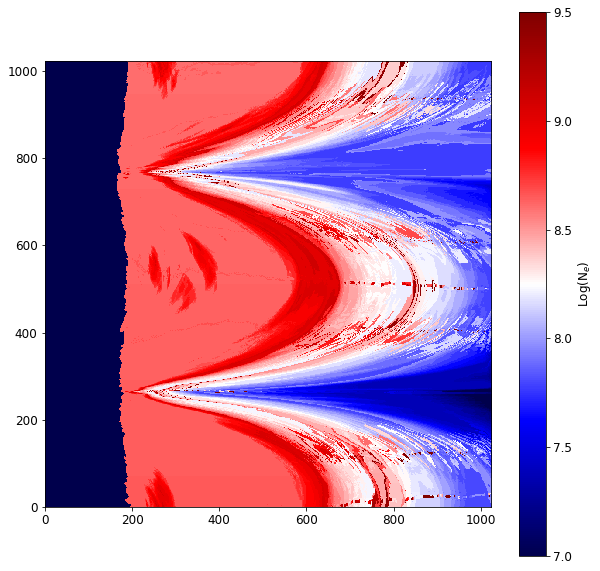

In [158]:
plt.figure()
plt.imshow(outparams_a[:,:,0,0],origin='center',cmap='seismic',vmin=7,vmax=9.5)
#plt.suptitle("CLE Density")
plt.colorbar(label='Log(N$_e$)')
plt.savefig('/home/alin/Desktop/cle_dens.png',dpi=100)

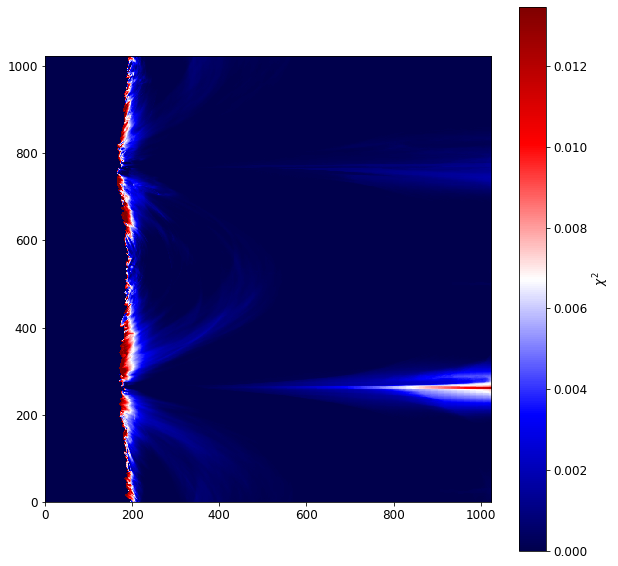

In [169]:
ab=plt.imshow(outparams_a[:,:,9,0],origin='center',cmap='seismic')
plt.colorbar(label='$\chi^2$')

plt.savefig('/home/alin/Desktop/cle_chi2.png',dpi=100)

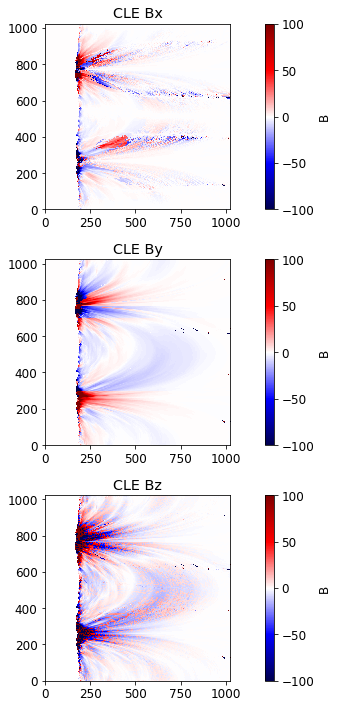

In [141]:
interp='none'
fig, plots = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
aa=plots[0].imshow(outparams_a[:,:,7,3]*5,interpolation=interp,cmap='seismic',vmin=-100,vmax=100)
plots[0].set_title("CLE Bx")
fig.colorbar(aa,ax=plots[0],label='B')

outparams_a[300:700,:,6,0]=-outparams_a[300:700,:,6,0]
ab=plots[1].imshow(-outparams_a[:,:,6,0]*2,interpolation=interp,cmap='seismic',vmin=-100,vmax=100)
plots[1].set_title("CLE By")
fig.colorbar(ab,ax=plots[1],label='B')

ac=plots[2].imshow(outparams_a[:,:,8,0]*3,interpolation=interp,cmap='seismic',vmin=-100,vmax=100)
plots[2].set_title("CLE Bz")
fig.colorbar(ac,ax=plots[2],label='B')

plt.tight_layout()
plt.savefig('/home/alin/Desktop/CLE.png',dpi=100)